In [1122]:
import pandas as pd
import seaborn as sns

In [1123]:
work_dir = '/Users/januszkoszucki/Work/Results/VoM'
outplots = Path(work_dir, 'plots')
sns.set(style='darkgrid', font_scale=1.7)

### 1. Drzewko KASPAH

### 2. Ogolna statystyka profagow

In [1124]:
phages = '/Users/januszkoszucki/Work/Results/PhageSearch/Results/KASPAH/prophages.txt'
metadata = '/Users/januszkoszucki/Work/Results/PhageSearch/Bacterial/KASPAH/KASPAH.txt'

phage_df = pd.read_csv(phages, sep='\t')

metadata_df = pd.read_csv(metadata, sep='\t')
metadata_df = metadata_df[['ID', 'ONT_data']]
metadata_df.fillna('draft', inplace=True)


phage_df['ID'] = phage_df['contig'].str.split('.', expand=True)[0]
phage_df = phage_df.merge(metadata_df, how='left', on='ID')

filt_kaspah99 = (phage_df['ONT_data'] == 'complete')
phage_df = phage_df.loc[filt_kaspah99].copy()
phage_df['confidence'] = pd.Categorical(phage_df['confidence'], ['high','medium','low','undetermined'])

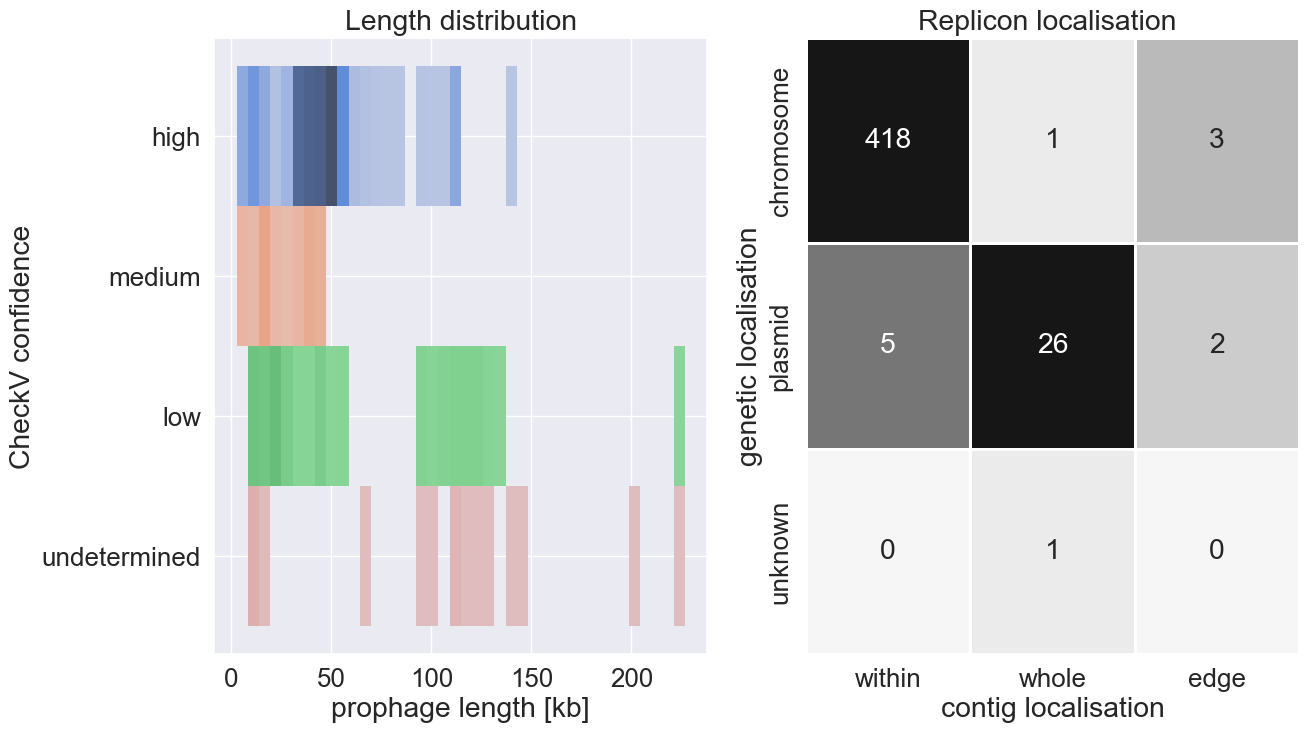

In [1128]:
fig, axes = plt.subplots(1,2, figsize=(14,8))

sns.histplot(data=phage_df, x='phage_length', y='confidence', hue='confidence', bins=40, legend=False, cbar=False, ax=axes[0])
sns.heatmap(data=localization_df, annot=True, cmap=sns.color_palette("Greys", 12), vmax=8, linewidths=0.8, linecolor='white', fmt='.16g', cbar=False, ax=axes[1])

localization_df = phage_df[['genetic_localisation', 'localization']].groupby(['genetic_localisation', 'localization']).size().reset_index()
localization_df.columns = ['genetic localisation', 'contig localisation', 'n']
localization_df = pd.pivot_table(localization_df, index='genetic localisation', columns = 'contig localisation').fillna(0)['n']
localization_df[localization_df.columns] = localization_df[localization_df.columns].astype(int)
localization_df = localization_df[['within', 'whole', 'edge']]

axes[0].set_title('Length distribution',x=0.5, y=1)
_ = axes[0].set_xlabel('prophage length [kb]')

axes[0].set_ylabel('CheckV confidence')
axes[1].set_title('Replicon localisation', x=0.49, y=1)

outfig = Path(outplots, 'detection_statistics.jpg')
fig.savefig(outfig, dpi=900)

### 3. Klasy funkcjonalne i dystrybujca długości białek fagowych

In [801]:
proteins = Path(work_dir, '0_curated_prophages', 'annotations-rbp-included.txt')
proteins_df = pd.read_csv(proteins, sep='\t')

proteins_df['end'] = pd.to_numeric(proteins_df['end'], downcast='integer')
proteins_df['start'] = pd.to_numeric(proteins_df['start'], downcast='integer')

proteins_df['protein length [aa]'] = ((proteins_df['end']+1 - proteins_df['start'])/3).astype('int')
proteins_df['square root of protein length [aa]'] = proteins_df['protein length [aa]'] ** (1/2)
proteins_df['cat'] = pd.Categorical(proteins_df['cat'], proteins_df.groupby('cat').size().sort_values().index)


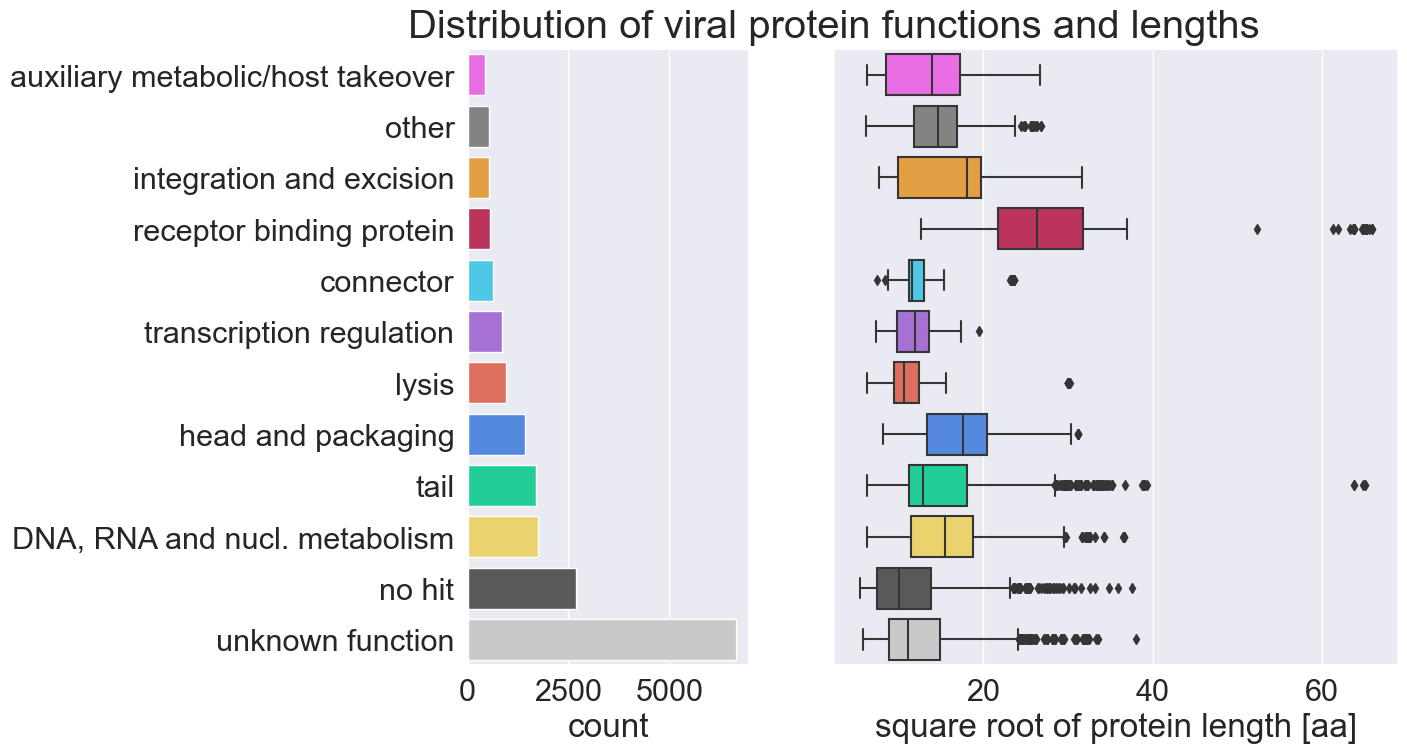

In [804]:
colors = {'integration and excision': '#fea328', 
          'head and packaging': '#3e83f6', 
          'transcription regulation': '#a861e3', 
          'connector': '#35d7ff', 
          'tail': '#07e9a2', 
          'lysis': '#f35f49', 
          'DNA, RNA and nucl. metabolism': '#ffdf59',
          'other': '#838383',
          'unknown function': '#c9c9c9',
          'auxiliary metabolic/host takeover': '#ff59f5',
          'receptor binding protein': '#d11d53',
          'no hit': '#595959'}

proteins_df.replace({'moron, auxiliary metabolic gene and host takeover':'auxiliary metabolic/host takeover', 'DNA, RNA and nucleotide metabolism': 'DNA, RNA and nucl. metabolism'},inplace=True)

fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,8), gridspec_kw={'width_ratios': [1,2]})


sns.countplot(data=proteins_df, y='cat', palette=colors, ax=axes[0])
sns.boxplot(data=proteins_df, x='square root of protein length [aa]', y='cat', palette=colors, ax=axes[1])

fig.suptitle('Distribution of viral protein functions and lengths', y=0.93, x=0.43)

axes[0].set_ylabel('')
axes[1].set_ylabel('')


outfig = Path(outplots, 'proteins.jpg')
fig.savefig(outfig, dpi=900)

### 4. Diversity and relationship of phage variants, RBPs & capsules

In [634]:
phariants = Path(work_dir, '1_ANImm', 'phariants.csv')
metadata = Path(work_dir, '2_RBPs', 'KASPAH99.txt')

phariants_df = pd.read_csv(phariants, sep='\t')
metadata_df = pd.read_csv(metadata, sep='\t')

phariants_df.columns = ['phariantID', 'phageID']


phages = Path(work_dir, '0_curated_prophages', 'prophages.txt')
phage_df = pd.read_csv(phages, sep='\t')
phage_df['phageID'] = phage_df.apply(lambda row: str(row['n']) + '_' + row['phageID'], axis=1)

phariants_df = phariants_df.merge(phage_df, on='phageID', how='left')

phariants_df['phariantID-ST'] = phariants_df.apply(lambda row: str(row['phariantID']) + '-' + row['ST'], axis=1)
phariants_counts_per_ST = phariants_df.drop_duplicates('phariantID-ST').groupby('ST').size().reset_index()
phariants_counts_per_ST.columns = ['ST', 'n_phariants']

klocus_counts_per_ST = metadata_df.groupby('ST').size().reset_index()
klocus_counts_per_ST.columns = ['ST', 'n_klocus']

phariants_klocus_df = phariants_counts_per_ST.merge(klocus_counts_per_ST, on='ST', how='outer')
phariants_klocus_df.fillna(0, inplace=True)

In [635]:
rbps_table = Path(work_dir, '2_RBPs', 'rbps.csv')
phariants = Path(work_dir, '2_RBPs', 'phariants.csv')
phages_table = Path(work_dir, '2_RBPs', 'prophages.txt')

phariants_df = pd.read_csv(phariants, sep='\t')
rbps_df = pd.read_csv(rbps_table, sep='\t')
phages_df = pd.read_csv(phages_table, sep='\t')

rbps_df = rbps_df.merge(phariants_df, on='phageID', how='left')
rbps_df['clusterID-ST'] = rbps_df.apply(lambda row: str(row['clusterID']) + '-' + row['ST'], axis=1)
rbps_df.drop_duplicates('clusterID-ST', inplace=True)
rbp_variant_per_ST = rbps_df.groupby('ST').size().to_frame().reset_index()
rbp_variant_per_ST.columns = ['ST', 'rbp variant per ST']

In [636]:
phariants_df.drop_duplicates('phariantID-ST', inplace=True)
phariants_per_ST = phariants_df.groupby('ST').size().to_frame().reset_index()
phariants_per_ST.columns = ['ST', 'phariant per ST']

In [637]:
rbp_variant_per_phariant_per_ST = phariants_per_ST.merge(rbp_variant_per_ST, on='ST', how='left')
rbp_variant_per_phariant_per_ST.fillna(0, inplace=True)

In [638]:
rbp_variant_per_phariant_per_ST['RBP variant per prophage variant per ST'] = np.round(rbp_variant_per_phariant_per_ST['rbp variant per ST'] / rbp_variant_per_phariant_per_ST['phariant per ST'], 3)
rbp_variant_per_phariant_per_ST = rbp_variant_per_phariant_per_ST.merge(klocus_counts_per_ST, on='ST', how='left')

/Users/januszkoszucki/opt/anaconda3/envs/python_env/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 28.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/januszkoszucki/opt/anaconda3/envs/python_env/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


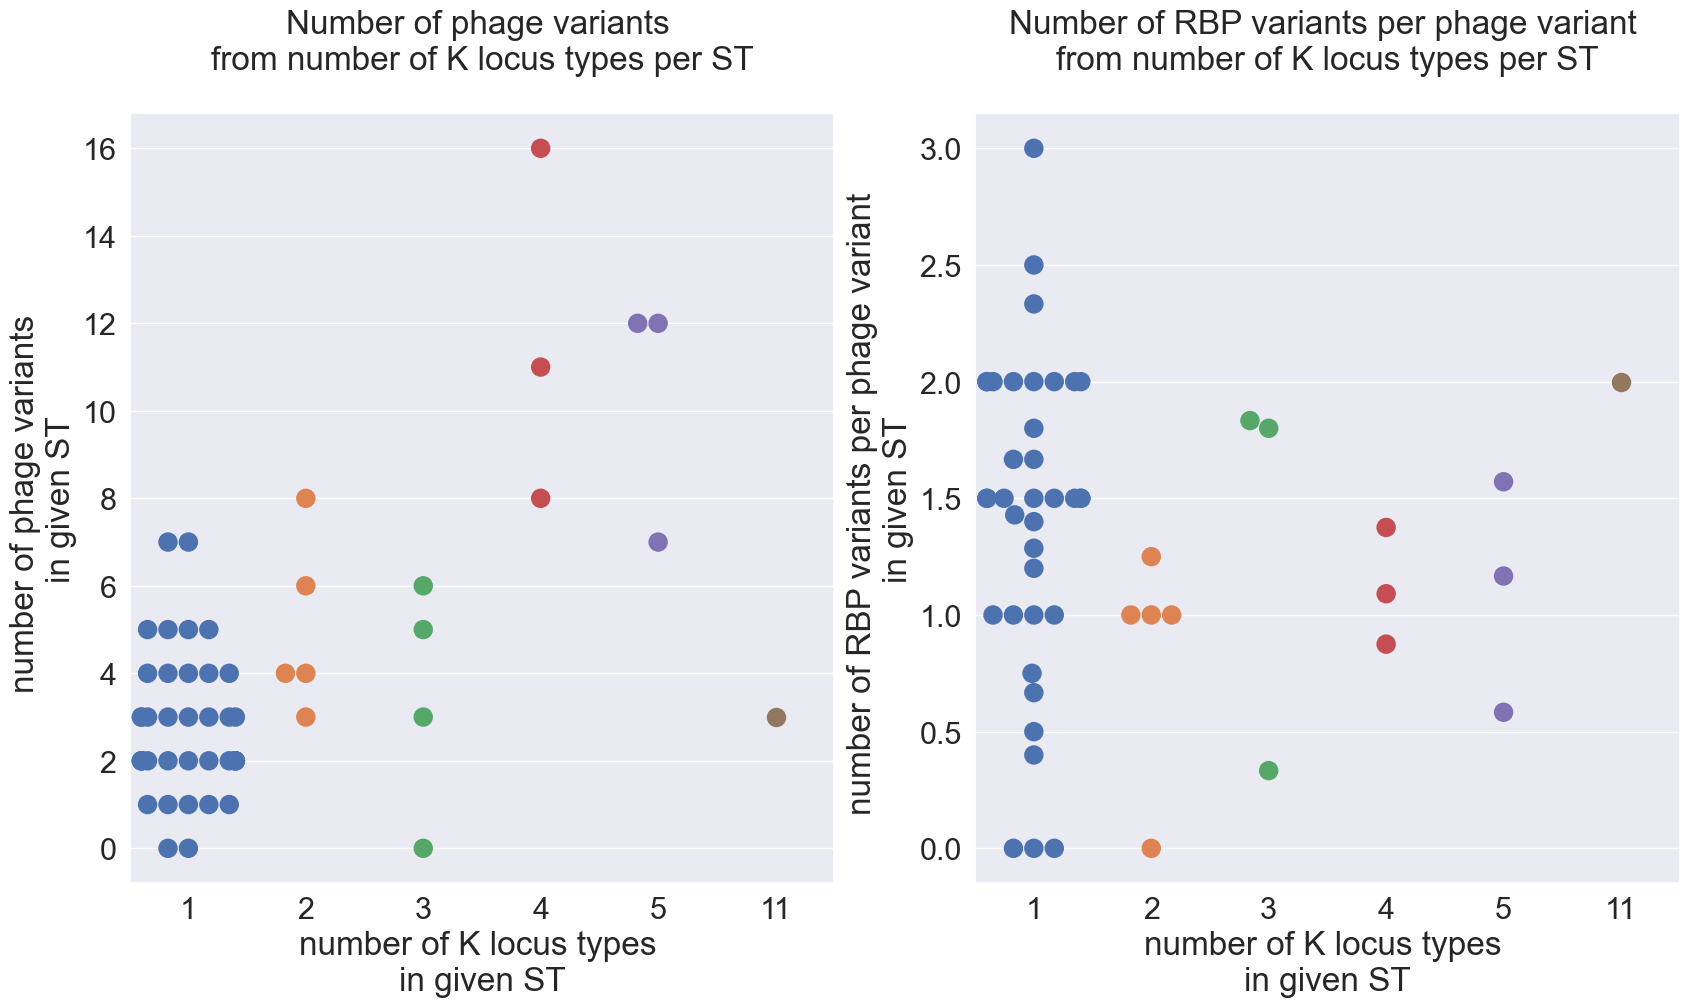

In [1138]:
sns.set(font_scale=2)
fig, axes = plt.subplots(1,2, sharex=True, figsize=(20,10))

sns.swarmplot(data=phariants_klocus_df, x='n_klocus', y='n_phariants', size=14, ax=axes[0])
sns.swarmplot(data=rbp_variant_per_phariant_per_ST, x='n_klocus', y='RBP variant per prophage variant per ST', size=14, ax=axes[1])

# fig.suptitle('Relationship between prophage/RBP diversity and bacterial capsule diversity', y=1.05)

axes[0].set_title('Number of phage variants \nfrom number of K locus types per ST\n')
axes[0].set_xlabel('number of K locus types \nin given ST')
axes[0].set_ylabel('number of phage variants \nin given ST')

axes[1].set_title('Number of RBP variants per phage variant \nfrom number of K locus types per ST\n ')
axes[1].set_xlabel('number of K locus types \nin given ST')
axes[1].set_ylabel('number of RBP variants per phage variant \nin given ST')

outfig = Path(outplots, 'variants_per_ST.jpg')
fig.savefig(outfig, dpi=900)

In [1039]:
phariants = Path(work_dir, '1_ANImm', 'phariants.csv')
phages = Path(work_dir, '0_curated_prophages', 'prophages.txt')


phages_df = pd.read_csv(phages, sep='\t')
phariants_df = pd.read_csv(phariants, sep='\t')

phariants_df.columns = ['phariantID', 'phageID']
phages_df['phageID'] = phages_df.apply(lambda row: str(row['n']) + '_' + row['phageID'], axis=1)

phages_df = phages_df.merge(phariants_df, on='phageID', how='left')
phages_df[['phariantID', 'phageID', 'phage_length']].sort_values(['phariantID', 'phage_length'], ascending=[True, False])

phages_df = phages_df[['phariantID', 'phageID', 'phage_length']]
phages_df = phages_df.iloc[phages_df.groupby(['phariantID'])['phage_length'].idxmax()].copy()

outrepr = Path(work_dir, '4_easyfig', '1_phariants-rep.txt')
phages_df['phageID'].to_csv(outrepr, sep='\t', index=False)

In [1]:
from subprocess import run

genbank_dir = '/Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color'
outreprsorted = Path(work_dir, '4_easyfig', '3_mashtree_leafs.txt')
tmp_df = pd.read_csv(outreprsorted, sep='\t')
files = [str(Path(genbank_dir, f'{name}.gb')) for name in tmp_df['mashtree_leaf'].to_list()]
files = ' '.join(files)


cmd = f'source ~/.bash_profile; conda activate easyfig; \
      cd ~/; python2 ~/MGG Dropbox/Janusz Koszucki/Work/Apps/Easyfig.py \
      -svg -legend double -leg_name note -f gene -f1 T -i 60 -filter -aln right \
      -o {work_dir}/4_easyfig/easyfig.svg {files}; \
      svg2png {work_dir}/4_easyfig/easyfig.svg -o {work_dir}/4_easyfig/easyfig.png; \
      convert {work_dir}/4_easyfig/easyfig.png -background white -flatten {work_dir}/4_easyfig/easyfig.jpg' 
cmd

In [1040]:
source ~/.bash_profile; conda activate easyfig;       cd ~/; python2 ~/MGG\ Dropbox/Janusz\ Koszucki/Work/Apps/Easyfig.py       -svg -legend double -leg_name note -f gene -f1 T -i 60 -filter -aln right       -o /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.svg /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/435_CONJURING.3146.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/347_TRANSFORMED.9797.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1664_LULLED.1879.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/983_IMPOVERISHING.1117.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1549_THERE.3644.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/321_MEHUNIMS.0091.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/623_WEIGHED.6307.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/541_RECOUER.4817.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/453_DELICACY.9048.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1921_GONG.8861.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1630_MOCKERS.2666.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/259_TALLER.1547.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1405_STROWS.6280.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/919_PULSATING.3182.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1491_ABSINTHE.6518.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1017_LOFTINESS.8105.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/686_TYRANT.8544.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1930_CLOTTING.7012.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1850_WILDERNESS.4672.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1548_PORTIONING.5802.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1507_TRENCHER.0700.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/848_IDENTICALLY.5583.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1717_SPIES.1581.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/986_FORMIDABLE.3191.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/85_YEELDS.4110.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/796_ORGANISED.3836.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1945_MOLES.8342.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1865_GUESSING.8863.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/147_COUNTERVAILS.7166.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/177_DUPED.7562.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1018_MULTIPLICITY.9114.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1187_LLAMAS.6257.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/540_STRETCH.4932.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/244_RESURRECTION.6252.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1154_AREA.3374.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/777_TARPAULINS.4052.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1667_ADVANCING.5654.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/969_ARMAGEDDON.2469.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1023_JERKING.1994.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1726_SUPPOSES.0145.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/920_RIPPLINGLY.3532.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/628_PUZZLING.7932.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/32_RESERVATION.3887.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/648_SMELLING.8554.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/179_SPRING.1532.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/797_BLOCKHEADS.5729.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1062_DISGUSTED.6712.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/251_TUMULI.5682.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/545_CANDID.2554.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/985_ASTOUNDING.8217.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/793_ICEBERG.6642.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/434_ORBICULAR.5374.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1856_AUDACIOUS.7512.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/439_ETRE.3862.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1816_THINKE.0650.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/739_WAFTER.2065.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/433_TROAS.7052.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1272_PECKING.4910.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/743_MEZAHAB.1211.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/625_DEHUMANISED.2797.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1246_CLIFFS.6234.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1221_THWARTING.7905.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/59_TAPHATH.3679.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/451_UNINTENTIONAL.6231.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1052_MINERS.8805.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1055_SITE.3763.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1666_AGREEABLE.0191.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/442_LICK.1237.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/27_TASTETH.8775.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/277_ORATOR.0792.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1051_UBIQUITY.9226.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1857_SHETH.0039.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1611_OVERGROWTH.4977.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/248_TIGERISH.0661.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1343_PRISMATIC.7811.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1057_SPREADING.8082.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/698_SHAMED.3615.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1714_KILLETH.0627.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1490_TWITCH.3606.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/461_VILLAINS.1277.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/319_MASONRIES.7426.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1846_UNEXAMPLED.0461.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1006_OUTSKIRTS.0475.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/663_DISMOUNTING.9339.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/615_GLIDE.7487.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1508_FEATURELESS.6449.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/441_LIPPES.4295.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1718_KNOCKED.0774.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1947_UNNAMED.3258.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1847_MOURNS.8398.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1936_FLEECED.0495.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1251_NAUSEOUS.6019.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/454_PITCHED.7541.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1819_UNINTENTIONALLY.9452.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1230_PATRONS.9860.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/741_LINED.7892.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/260_BUTTOCKS.6500.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1614_ZEDEKIAH.7045.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1937_CHOICEST.0129.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1303_IMPOSED.3971.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/618_REFUGEE.8371.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/281_ARTIMEDORUS.4153.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/700_FATFLESHED.4740.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/688_PEDAHZUR.1773.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/30_INDORSEMENT.8309.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/409_INCOMPUTABLE.6909.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1231_OBTRUDING.4792.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1228_PHRENOLOGY.1675.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/245_SIGNIFICANCY.7679.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1823_CONCEPTION.9006.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1923_NEERELY.5665.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1668_MILCHE.4528.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1402_VITALS.4711.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1489_BOWER.5541.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1407_NEWCASTLE.0553.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1724_LECHERIE.7652.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1061_ADORED.8742.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/966_SATIETY.8359.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/875_SIGNOR.2832.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1920_AGREE.6447.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1155_WARFARE.6132.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1663_MUTENESS.7285.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1019_DISTILL.5026.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/792_BAMAH.0167.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1818_IRKSOMENESS.9206.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1267_REFRESHMENTS.5077.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1252_WENDED.3954.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/276_BEAVERS.1907.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/452_PIERS.1437.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/647_BIZANCE.5953.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1944_SPROUT.8074.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/861_TROUBLER.6602.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1863_REPAIR.8842.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/626_CHIAROSCURO.8253.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1722_SMUGGLED.3911.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1720_FLORENCE.9775.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1059_REALM.8427.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1344_ESTRAY.1729.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/876_MAPPLE.0056.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/616_APPII.0193.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1058_SUBTIL.2178.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1538_BESTIR.0110.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1612_CELEBRATES.5631.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1409_DIRECTETH.2444.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1723_CAMPHORATED.7654.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1249_SWAGGER.2134.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/740_IMMANUEL.5912.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/666_DERBY.9359.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1827_DISSUADED.0464.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1270_WITLESS.2670.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1815_SHASTA.3560.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1674_INVUNERABLE.8994.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/28_VNACCOMPANIED.1358.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1250_LEAPES.4217.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1186_ADOPTION.3280.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/738_JESHUAH.9612.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/736_UNTROUBLED.0807.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/246_RAGGES.6132.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/737_OPERATES.8253.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/664_RESPECTER.4801.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1299_GUESSES.7308.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/646_LIBNI.1969.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1401_BATCH.2700.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/60_REARING.1310.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1509_LECHEROUS.3144.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/320_WEYWARD.4366.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1492_WEENIEST.5940.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/699_COMMING.5719.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1537_SABLE.5352.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1220_GAZITES.0725.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/279_SHUHAMITES.8277.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1673_YNCH.2416.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1056_SPLITS.7742.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/24_DEVISING.7682.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1896_MERCENARY.7809.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1406_DISSOLUTION.1441.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1021_OTTO.9884.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1441_INLOOP.5049.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1403_SPOUSE.1474.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1007_NOWAYS.7746.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/8_CRUSTED.1621.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/964_LAGOON.2181.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/316_MINIONS.8624.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1438_DISSOLUTION.9161.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1919_ASSAULTS.0587.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/408_CYLINDRICAL.0448.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/851_MEMBRANES.5213.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/705_SANGUINARY.8669.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/348_IDLING.0379.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1156_IDIOT.8199.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/914_ZIPPORAH.7916.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1008_AMALTHEA.4455.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1190_AZALIAH.3079.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/984_GERMAINE.3013.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1715_SHAVED.3653.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1895_DEITY.7695.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/649_AVOWS.4678.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/665_UNANNOUNC.7897.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/440_NEWTRALL.1444.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1463_CORNICE.4143.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/317_LOWERS.1396.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/261_UNTRIED.9755.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1948_BUTLERS.5840.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/650_MISTY.8507.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/862_MYSTERIES.8913.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1609_DISENGAGEMENT.9480.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/1552_UNCONQUERABLE.7342.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/617_ORNAMENTS.5974.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank/735_SOUNDS.1369.gb;       svg2png /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.svg -o /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.png;       convert /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.png -background white -flatten /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.jpg

In [ ]:
source ~/.bash_profile; conda activate easyfig;       cd ~/; python2 ~/MGG\ Dropbox/Janusz\ Koszucki/Work/Apps/Easyfig.py       -svg -legend double -leg_name note -f gene -f1 T -i 60 -filter -aln right       -o /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.svg /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/435_CONJURING.3146.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/347_TRANSFORMED.9797.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1664_LULLED.1879.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/983_IMPOVERISHING.1117.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1549_THERE.3644.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/321_MEHUNIMS.0091.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/623_WEIGHED.6307.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/541_RECOUER.4817.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/453_DELICACY.9048.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1921_GONG.8861.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1630_MOCKERS.2666.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/259_TALLER.1547.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1405_STROWS.6280.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/919_PULSATING.3182.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1491_ABSINTHE.6518.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1017_LOFTINESS.8105.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/686_TYRANT.8544.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1930_CLOTTING.7012.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1850_WILDERNESS.4672.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1548_PORTIONING.5802.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1507_TRENCHER.0700.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/848_IDENTICALLY.5583.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1717_SPIES.1581.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/986_FORMIDABLE.3191.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/85_YEELDS.4110.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/796_ORGANISED.3836.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1945_MOLES.8342.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1865_GUESSING.8863.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/147_COUNTERVAILS.7166.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/177_DUPED.7562.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1018_MULTIPLICITY.9114.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1187_LLAMAS.6257.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/540_STRETCH.4932.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/244_RESURRECTION.6252.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1154_AREA.3374.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/777_TARPAULINS.4052.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1667_ADVANCING.5654.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/969_ARMAGEDDON.2469.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1023_JERKING.1994.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1726_SUPPOSES.0145.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/920_RIPPLINGLY.3532.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/628_PUZZLING.7932.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/32_RESERVATION.3887.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/648_SMELLING.8554.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/179_SPRING.1532.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/797_BLOCKHEADS.5729.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1062_DISGUSTED.6712.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/251_TUMULI.5682.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/545_CANDID.2554.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/985_ASTOUNDING.8217.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/793_ICEBERG.6642.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/434_ORBICULAR.5374.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1856_AUDACIOUS.7512.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/439_ETRE.3862.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1816_THINKE.0650.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/739_WAFTER.2065.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/433_TROAS.7052.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1272_PECKING.4910.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/743_MEZAHAB.1211.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/625_DEHUMANISED.2797.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1246_CLIFFS.6234.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1221_THWARTING.7905.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/59_TAPHATH.3679.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/451_UNINTENTIONAL.6231.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1052_MINERS.8805.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1055_SITE.3763.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1666_AGREEABLE.0191.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/442_LICK.1237.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/27_TASTETH.8775.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/277_ORATOR.0792.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1051_UBIQUITY.9226.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1857_SHETH.0039.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1611_OVERGROWTH.4977.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/248_TIGERISH.0661.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1343_PRISMATIC.7811.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1057_SPREADING.8082.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/698_SHAMED.3615.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1714_KILLETH.0627.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1490_TWITCH.3606.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/461_VILLAINS.1277.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/319_MASONRIES.7426.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1846_UNEXAMPLED.0461.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1006_OUTSKIRTS.0475.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/663_DISMOUNTING.9339.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/615_GLIDE.7487.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1508_FEATURELESS.6449.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/441_LIPPES.4295.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1718_KNOCKED.0774.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1947_UNNAMED.3258.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1847_MOURNS.8398.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1936_FLEECED.0495.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1251_NAUSEOUS.6019.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/454_PITCHED.7541.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1819_UNINTENTIONALLY.9452.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1230_PATRONS.9860.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/741_LINED.7892.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/260_BUTTOCKS.6500.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1614_ZEDEKIAH.7045.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1937_CHOICEST.0129.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1303_IMPOSED.3971.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/618_REFUGEE.8371.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/281_ARTIMEDORUS.4153.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/700_FATFLESHED.4740.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/688_PEDAHZUR.1773.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/30_INDORSEMENT.8309.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/409_INCOMPUTABLE.6909.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1231_OBTRUDING.4792.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1228_PHRENOLOGY.1675.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/245_SIGNIFICANCY.7679.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1823_CONCEPTION.9006.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1923_NEERELY.5665.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1668_MILCHE.4528.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1402_VITALS.4711.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1489_BOWER.5541.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1407_NEWCASTLE.0553.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1724_LECHERIE.7652.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1061_ADORED.8742.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/966_SATIETY.8359.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/875_SIGNOR.2832.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1920_AGREE.6447.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1155_WARFARE.6132.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1663_MUTENESS.7285.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1019_DISTILL.5026.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/792_BAMAH.0167.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1818_IRKSOMENESS.9206.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1267_REFRESHMENTS.5077.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1252_WENDED.3954.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/276_BEAVERS.1907.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/452_PIERS.1437.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/647_BIZANCE.5953.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1944_SPROUT.8074.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/861_TROUBLER.6602.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1863_REPAIR.8842.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/626_CHIAROSCURO.8253.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1722_SMUGGLED.3911.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1720_FLORENCE.9775.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1059_REALM.8427.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1344_ESTRAY.1729.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/876_MAPPLE.0056.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/616_APPII.0193.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1058_SUBTIL.2178.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1538_BESTIR.0110.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1612_CELEBRATES.5631.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1409_DIRECTETH.2444.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1723_CAMPHORATED.7654.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1249_SWAGGER.2134.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/740_IMMANUEL.5912.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/666_DERBY.9359.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1827_DISSUADED.0464.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1270_WITLESS.2670.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1815_SHASTA.3560.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1674_INVUNERABLE.8994.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/28_VNACCOMPANIED.1358.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1250_LEAPES.4217.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1186_ADOPTION.3280.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/738_JESHUAH.9612.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/736_UNTROUBLED.0807.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/246_RAGGES.6132.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/737_OPERATES.8253.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/664_RESPECTER.4801.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1299_GUESSES.7308.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/646_LIBNI.1969.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1401_BATCH.2700.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/60_REARING.1310.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1509_LECHEROUS.3144.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/320_WEYWARD.4366.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1492_WEENIEST.5940.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/699_COMMING.5719.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1537_SABLE.5352.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1220_GAZITES.0725.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/279_SHUHAMITES.8277.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1673_YNCH.2416.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1056_SPLITS.7742.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/24_DEVISING.7682.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1896_MERCENARY.7809.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1406_DISSOLUTION.1441.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1021_OTTO.9884.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1441_INLOOP.5049.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1403_SPOUSE.1474.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1007_NOWAYS.7746.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/8_CRUSTED.1621.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/964_LAGOON.2181.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/316_MINIONS.8624.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1438_DISSOLUTION.9161.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1919_ASSAULTS.0587.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/408_CYLINDRICAL.0448.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/851_MEMBRANES.5213.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/705_SANGUINARY.8669.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/348_IDLING.0379.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1156_IDIOT.8199.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/914_ZIPPORAH.7916.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1008_AMALTHEA.4455.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1190_AZALIAH.3079.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/984_GERMAINE.3013.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1715_SHAVED.3653.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1895_DEITY.7695.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/649_AVOWS.4678.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/665_UNANNOUNC.7897.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/440_NEWTRALL.1444.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1463_CORNICE.4143.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/317_LOWERS.1396.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/261_UNTRIED.9755.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1948_BUTLERS.5840.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/650_MISTY.8507.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/862_MYSTERIES.8913.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1609_DISENGAGEMENT.9480.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/1552_UNCONQUERABLE.7342.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/617_ORNAMENTS.5974.gb /Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color/735_SOUNDS.1369.gb;       svg2png /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.svg -o /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.png;       convert /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.png -background white -flatten /Users/januszkoszucki/Work/Results/VoM/4_easyfig/easyfig.jpg

In [1058]:
path = '/Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color'
# p = list(Path(path).glob('*gb'))

for p in list(Path(path).glob('*gb')):
    with open(p, 'r+') as f:
        file = f.read()

    new_file = file.replace('139 117 0','209 29 83')

    with open(p, 'w+') as f:
        f.write(new_file)

In [ ]:
genbank_dir = '/Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/3_genbank_rbps_new_color'

In [1068]:
annot = '/Users/januszkoszucki/Work/Results/VoM/0_curated_prophages/annotations-rbp-included.txt'
annot_df = pd.read_csv(annot, sep='\t')
annot_df = annot_df.loc[annot_df['cat'] == 'receptor binding protein']

In [1069]:
annot_df.head(2)

,n,phageID,proteinID,start,end,strand,cat,annot,phrog,RBP
39,40,1006_OUTSKIRTS.0475,PROTEIN_40,27446,29671,1,receptor binding protein,receptor binding protein,Ola & Sebastian,True
41,42,1006_OUTSKIRTS.0475,PROTEIN_42,30038,31198,1,receptor binding protein,receptor binding protein,phrog_4618,False


In [1133]:
files = list(Path(genbank_dir).glob('*gb'))
# file = files[0]
# print(file)

for file in files:
    record = list(SeqIO.parse(file, 'genbank'))[0]

    new_features = []
    for f in record.features:
        filt_phage = (annot_df['phageID'] == file.stem)
        filt_feature = (annot_df['start'] == int(f.location.start)+1) & (annot_df['end'] == int(f.location.end)) & (annot_df['strand'] == int(f.location.strand))

        feature_df = annot_df.loc[filt_phage & filt_feature].copy()
        if len(feature_df) > 0: 
            feature_df.iloc[0]
            qualifiers = f.qualifiers
            qualifiers['note'], qualifiers['product'], qualifiers['colour'] = 'receptor binding protein', 'receptor binding protein', '209 29 83'
        new_features.append(f)

        record.features = new_features

        SeqIO.write(record, file, 'genbank')
    

/Users/januszkoszucki/opt/anaconda3/envs/python_env/lib/python3.10/site-packages/Bio/SeqIO/InsdcIO.py:726: BiopythonWarning: Increasing length of locus line to allow long name. This will result in fields that are not in usual positions.
  warnings.warn(
